In [1]:
!pip install --no-cache-dir --upgrade git+https://github.com/evfro/polara.git@develop#egg=polara

  Cloning https://github.com/evfro/polara.git (to revision develop) to /tmp/pip-install-zw8ao9bx/polara_1e205edacd554a9999d2ceeb541ef19c
  Running command git clone --filter=blob:none --quiet https://github.com/evfro/polara.git /tmp/pip-install-zw8ao9bx/polara_1e205edacd554a9999d2ceeb541ef19c
  Running command git checkout -b develop --track origin/develop
  Switched to a new branch 'develop'
  Branch 'develop' set up to track remote branch 'develop' from 'origin'.
  Resolved https://github.com/evfro/polara.git to commit 8e48cfd88e616ca53f8bbda1702a3e2c8abaf38e
  Preparing metadata (setup.py) ... done
  Created wheel for polara: filename=polara-0.7.2.dev0-py3-none-any.whl size=89447 sha256=dc6f94072033aedcae532d5a0246e82d8b0fa314e73fc036bd8ac602c74ebbd7
  Stored in directory: /tmp/pip-ephem-wheel-cache-47lmwovz/wheels/3f/3a/1f/42058978e585b23c384652846b96b72870f3c8c12976cdac50
Successfully built polara


# Imports

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

import random
import numpy as np
import pandas as pd
import time
import os
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
from torch.utils import data
from torch.autograd import Variable
import pickle
import warnings
from sklearn.preprocessing import OneHotEncoder

from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all"

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

import polara
from polara import get_movielens_data
from polara.tools.display import print_frames

# Data Preparation

## Download

The data about users' ratings and movies will be downloaded using polara.

In [3]:
# ?get_movielens_data

In [4]:
ratings, genres = get_movielens_data(
    get_genres=True,
    split_genres=False,
    include_time=True
)

ratings.shape

(1000209, 4)

In [5]:
movies = genres
movies.shape

(3883, 3)

The data about users is stored in a separate file as Polara doesn't offer possibility to download user features.

In [6]:
users = pd.read_csv("users.csv")
users.shape

(6040, 5)

## Description

In [7]:
ratings.nunique()

userid         6040
movieid        3706
rating            5
timestamp    458455
dtype: int64

In [8]:
ratings.head()

,userid,movieid,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [9]:
movies.head()

,movieid,movienm,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [10]:
users.head()

,userid,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


Text(0.5, 1.0, 'Ratings Distribution')

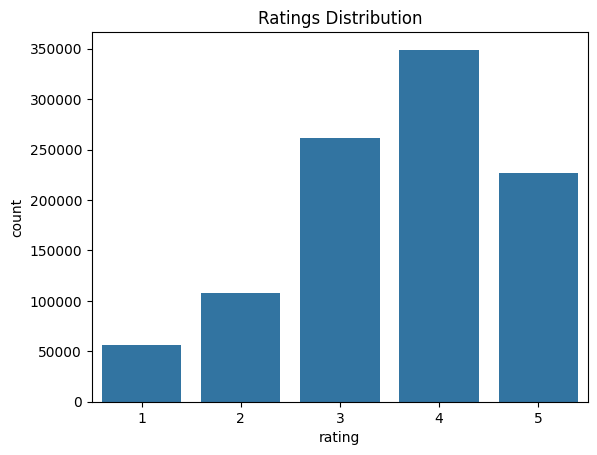

In [11]:
sns.countplot(x = "rating", data = ratings).set_title("Ratings Distribution")

## Preprocessing

### Movie data

Genre splitting

In [12]:
genres = set()

for movie_genres in movies["genres"]:
    for genre in movie_genres.split("|"):
        genres.add(genre)

In [13]:
col = 2
for genre in genres:
    movies.insert(col, genre, np.zeros(len(movies["genres"]), int))
    col += 1

In [14]:
for index, row in movies.iterrows():
    for genre in row["genres"].split("|"):
        movies.loc[index, genre] = 1

movies = movies.drop(["movienm", "genres"], axis = 1)
movies.head()

,movieid,War,Romance,Documentary,Comedy,Drama,Crime,Children's,Animation,Fantasy,Thriller,Sci-Fi,Western,Musical,Horror,Film-Noir,Action,Mystery,Adventure
0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1
2,3,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Ratings data

Done with a reference to [stream data of users preprocessing](https://github.com/kfoofw/bandit_simulations/blob/master/python/contextual_bandits/notebooks/LinUCB_hybrid.ipynb).

#### Top-n movies collection

In [15]:
n = 30

top_movies_index = ratings.groupby("movieid").count().sort_values("userid", ascending = False).head(n).reset_index()["movieid"]
top_movies_index.head()

0    2858
1     260
2    1196
3    1210
4     480
Name: movieid, dtype: int64

In [16]:
top_movies = movies[movies.movieid.isin(top_movies_index)]
top_movies.shape

(30, 19)

In [17]:
filtered_ratings_original = ratings[ratings["movieid"].isin(top_movies_index)]
filtered_ratings_original.shape

(73972, 4)

In [18]:
filtered_ratings_original["reward"] = np.where(filtered_ratings_original["rating"] < 5, 0, 1)
filtered_ratings_original.head()

<ipython-input-18-0b212c230073>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_ratings_original["reward"] = np.where(filtered_ratings_original["rating"] < 5, 0, 1)


,userid,movieid,rating,timestamp,reward
5,1,1197,3,978302268,0
22,1,1270,5,978300055,1
23,1,527,5,978824195,1
26,1,1097,4,978301953,0
38,1,2762,4,978302091,0


In [19]:
filtered_ratings_original = filtered_ratings_original.reset_index(drop = True)

<Axes: >

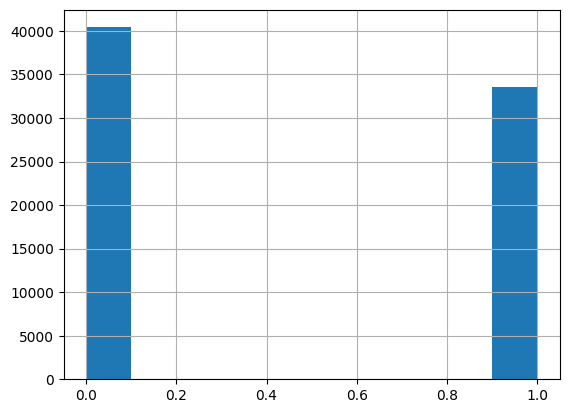

In [20]:
filtered_ratings_original.reward.hist()

In [21]:
reward_mean = filtered_ratings_original.reward.mean()
reward_mean

0.45364462228951496

In [22]:
# Reshuffling rows to randomise it
np.random.seed(42)
filtered_ratings = filtered_ratings_original.reindex(np.random.permutation(filtered_ratings_original.index)).reset_index(drop = True)
filtered_ratings = filtered_ratings_original.reset_index(drop = True)

### User data

Done with a reference to [user data preprocessing](https://github.com/kfoofw/bandit_simulations/blob/master/python/contextual_bandits/notebooks/LinUCB_hybrid.ipynb).

In [23]:
bins = [0, 20, 30, 40, 50, 60, np.inf]
names = ['<20', '20-29', '30-39','40-49', '51-60', '60+']

users['agegroup'] = pd.cut(users['age'], bins, labels=names)
users = users.drop(["age"], axis = 1)
users.head()

,userid,gender,occupation,zipcode,agegroup
0,1,F,10,48067,<20
1,2,M,16,70072,51-60
2,3,M,15,55117,20-29
3,4,M,7,02460,40-49
4,5,M,20,55455,20-29


In [24]:
users["occupation"] = users["occupation"].map({
	  0:  "other or not specified",
	  1:  "academic/educator",
	  2:  "artist",
	  3:  "clerical/admin",
	  4:  "college/grad student",
	  5:  "customer service",
	  6:  "doctor/health care",
	  7:  "executive/managerial",
	  8:  "farmer",
	  9:  "homemaker",
	 10:  "K-12 student",
	 11:  "lawyer",
	 12:  "programmer",
	 13:  "retired",
	 14:  "sales/marketing",
	 15:  "scientist",
	 16:  "self-employed",
	 17:  "technician/engineer",
	 18:  "tradesman/craftsman",
	 19:  "unemployed",
	 20:  "writer"})

In [25]:
columnsToEncode = ["agegroup", "gender", "occupation"]
myEncoder = OneHotEncoder(sparse = False, handle_unknown='ignore')
myEncoder.fit(users[columnsToEncode])

users_d = users.drop(columnsToEncode, axis = 1)

users = pd.concat([users_d,
                   pd.DataFrame(myEncoder.transform(users[columnsToEncode]).astype(int),
                   columns = myEncoder.get_feature_names_out(columnsToEncode))],
                                                         axis=1).reindex()
users = users.drop(["zipcode"], axis = 1)
print(users.shape)
users.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


OneHotEncoder(handle_unknown='ignore', sparse=False, sparse_output=False)

(6040, 29)


,userid,agegroup_20-29,agegroup_30-39,agegroup_40-49,agegroup_51-60,agegroup_<20,gender_F,gender_M,occupation_K-12 student,occupation_academic/educator,...,occupation_other or not specified,occupation_programmer,occupation_retired,occupation_sales/marketing,occupation_scientist,occupation_self-employed,occupation_technician/engineer,occupation_tradesman/craftsman,occupation_unemployed,occupation_writer
0,1,0,0,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,3,1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,4,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


# Neural Thompson Sampling

The algorithm for Neural Thomspon Sampling is described at [(Zhang, Weitong, et al., 2020)](https://arxiv.org/pdf/2010.00827). The implementation from [Neural-Thompson-Sampling](https://github.com/RonyAbecidan/Neural-Thompson-Sampling/tree/main) repository was transformed to obtain CTR simulation.

In [39]:
class NeuralTSMean(nn.Module):

    def __init__(self, d, m, L):

        super().__init__()
        self.d = d
        self.m = m
        self.L = L

        self.layers = [nn.Linear(d, m, bias=False).to(device), nn.ReLU().to(device)]

        for i in range (1, self.L - 1):

            self.layers.append(nn.Linear(m, m, bias=False))
            self.layers.append(nn.ReLU())

        self.layers.append(nn.Linear(m, 1, bias=False))
        self.layers.append(nn.ReLU())
        self.sequential = nn.ModuleList(self.layers)

    # theta0 = (vec(W1), ..., vec(WL))
    def init_parameters(self):

        W0 = np.sqrt(4 / self.m) * torch.randn((self.m, (self.d // 2) - 1)).to(device)
        W0 = torch.cat([W0,
                        torch.zeros(self.m, 1).to(device),
                        torch.zeros(self.m, 1).to(device),
                        W0], axis=1)
        self.sequential[0].weight.data = W0

        for i in range(2, self.L - 1):

            # Initialize the weights of nn.Linear(...)
            if i % 2 == 0:

                W = np.sqrt(4 / self.m) * torch.randn((self.m, (self.m // 2) - 1)).to(device)
                self.sequential[i].weight.data = torch.cat([W,
                                torch.zeros(self.m, 1).to(device),
                                torch.zeros(self.m, 1).to(device),
                                W], axis=1).to(float)

        w = np.sqrt(2 / self.m) * torch.randn(1, self.m // 2).to(device)
        self.sequential[-2].weight.data  = torch.cat([w, -w], axis=1)


    def forward(self, x_array):

        x_array = x_array.to(torch.float)

        # Pass the input tensor through each of operations
        for layer in self.sequential:
            x_array = layer(x_array)

        return np.sqrt(self.m) * x_array

In [40]:
## Flatten a large tuple containing tensors of different sizes
def flatten(tensor):

    T = torch.tensor([]).to(device)

    for element in tensor:

        T = torch.cat([T, element.to(device).flatten()])

    return T

# Concatenation of all the parameters of a NN
def get_theta(model):

    return flatten(model.parameters())

# Loss function of the Neural Thompson Sampling (min L(theta))
def criterion(estimated_reward, reward, m, regular_param, theta, theta_0):

    return 0.5 * torch.sum(torch.square(estimated_reward - reward)) + 0.5 * m * regular_param * torch.square(torch.norm(theta - theta_0))

# Make the transformation of the context vectors
# so that the assumptions of the authors are met
def transform(x):

    return np.vstack([x / (np.sqrt(2) * np.linalg.norm(x)),
                      x / (np.sqrt(2) * np.linalg.norm(x))]).reshape(-1)

In [41]:
# Create class object for a single Neural Thomspon Sampling arm
class neural_thompson_sampling_arm():

    def __init__(self, arm_index, nu, L, d, m, regular_param, estimator, criterion):

        self.arm_index = arm_index
        self.regular_param = regular_param
        self.d = d
        self.nu = nu
        self.L = L
        self.m = m

        self.neural_mean = estimator(self.d, self.m, self.L)
        self.neural_mean.to(device)
        self.optimizer = torch.optim.Adam(self.neural_mean.parameters(),
                                          lr = 0.001)
        self.current_loss = 0
        self.rewards = []
        self.criterion = criterion

        self.t = 1
        self.neural_mean.init_parameters()
        self.theta_zero = get_theta(self.neural_mean)
        self.num_params = (self.theta_zero).size(0)
        self.U = torch.Tensor(self.regular_param * np.eye(self.num_params)).to(device)
        self.U_inv = torch.Tensor((1 / self.regular_param) * np.eye(self.num_params)).to(device)

    def estimate_reward(self, x_array):

        f = self.neural_mean.forward(x_array)
        g = torch.autograd.grad(outputs = f, inputs = self.neural_mean.parameters())
        g = flatten(g).detach()
        sigma_squared = (self.regular_param * (1 / self.m) * torch.matmul(torch.matmul(g.T, self.U_inv), g)).to(device)
        sigma = torch.sqrt(sigma_squared)
        arm_reward = (self.nu) * (sigma) * torch.randn(1).to(device) + f.detach()

        return arm_reward

    def reward_update(self, reward, x_array):

        estimated_rewards = self.neural_mean(torch.Tensor(x_array).to(device))
        self.rewards.append(reward)
        self.current_loss = self.criterion(estimated_rewards.to(device),
                                           torch.Tensor(torch.Tensor(self.rewards)).to(device),
                                           self.m, self.regular_param,
                                           get_theta(self.neural_mean),
                                           self.theta_zero)

        if self.t == 1:
            self.current_loss.backward(retain_graph=True)

        else:
            self.current_loss.backward()

        self.optimizer.step()
        self.optimizer.zero_grad()
        f_t = self.neural_mean(x_array)
        g = torch.autograd.grad(outputs = f_t,
                                inputs = self.neural_mean.parameters())
        g = flatten(g)
        g = g / (np.sqrt(self.m))

        self.U += torch.matmul(g, g.T).to(device)
        self.U_inv = torch.inverse(torch.diag(torch.diag(self.U)))
        self.t += 1

In [42]:
class neural_thompson_sampling_policy():

    def __init__(self, K_arms, nu, L, d, m, regular_param, estimator, criterion):

        self.K_arms = K_arms
        self.nts_arms = [neural_thompson_sampling_arm(arm_index = i, nu = nu, L = L,
                                                      d = d, m = m,
                                                      regular_param = regular_param,
                                                      estimator = estimator,
                                                      criterion = criterion) for i in range(K_arms)]

    def select_arm(self, x_array):

        estimated_rewards=[]

        for arm_index in range(self.K_arms):

            estimated_reward = self.nts_arms[arm_index].estimate_reward(x_array)
            estimated_rewards.append(estimated_reward.detach().item())

        # Choose the arm which gets highest expected reward
        chosen_arm = np.argmax(estimated_rewards)
        estimated_reward = np.max(estimated_rewards)

        return chosen_arm, estimated_reward

    def store_arm_index(self, arms_index_array):

        # Loop through all arms to store their indices
        for i in range(self.K_arms):

            self.nts_arms[i].arm_index = arms_index_array[i]

In [44]:
def ctr_nts_simulator(K_arms, d, nu, L, m, epochs, regular_param, estimator, criterion):

    np.random.seed(42)

    # Initiate policy
    neural_ts_object = neural_thompson_sampling_policy(K_arms = K_arms, nu = nu, L = L,
                                                       d = d, m = m, regular_param = regular_param,
                                                       estimator = estimator, criterion = criterion)

    # Store specific arm_index
    neural_ts_object.store_arm_index(top_movies_index.to_numpy())

    # Instantiate trackers
    time_steps = 0
    cumulative_rewards = 0
    ctr = []

    for epoch_iter in range(epochs):

        print("Epoch: " + str(epoch_iter))

        if epoch_iter == 0:

            # Start with filtered ratings first
            ratings = filtered_ratings.copy()

            # Initiate unused_ratings
            unused_ratings = pd.DataFrame(columns = ["userid", "movieid", "rating",
                                                     "timestamp", "reward"])

        else:
            # Recycle unused data
            ratings = unused_ratings.copy().reset_index(drop = True)
            unused_ratings = pd.DataFrame(columns = ["userid", "movieid", "rating",
                                                     "timestamp", "reward"])

        for i in range(len(ratings)):

            if i % 5000 == 0:
                print("Step " + str(i))

            user_id = ratings.loc[i, "userid"]
            movie_id = ratings.loc[i, "movieid"]

            # x: User features
            users_x_array = np.array(users.query("userid == @user_id").drop("userid",
                                                                              axis = 1))

            users_x_array = torch.from_numpy(users_x_array).to(device)
            ratings_reward = ratings.loc[i, "reward"]

            # Find policy's chosen arm based on input covariates at current time step
            chosen_arm_index, estimated_reward = neural_ts_object.select_arm(users_x_array)

            # Check if arm_index is the same as data_arm (ie same actions were chosen)
            if neural_ts_object.nts_arms[chosen_arm_index].arm_index == movie_id:

                # Use reward information for the chosen arm to update
                neural_ts_object.nts_arms[chosen_arm_index].reward_update(estimated_reward,
                                                                          users_x_array)

                # For CTR calculation
                time_steps += 1
                cumulative_rewards += ratings_reward
                ctr.append(cumulative_rewards / time_steps)

            else:

                # Recycle data
                unused_ratings.loc[len(unused_ratings.index)] = ratings.iloc[i]

    return {"time_steps": time_steps,
            "cumulative_rewards": cumulative_rewards,
            "ctr": ctr,
            "policy": neural_ts_object}

In [45]:
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
m = 20
simulation_neural_thompson_sampling_m20 = ctr_nts_simulator(K_arms = n, d = 28, nu = 1,
                                                            L = 3, m = m,
                                                            epochs = 1,
                                                            regular_param = 1.5,
                                                            estimator = NeuralTSMean,
                                                            criterion = criterion)

Epoch: 0
Step 0
Step 5000
Step 10000
Step 15000
Step 20000
Step 25000
Step 30000
Step 35000
Step 40000
Step 45000
Step 50000
Step 55000
Step 60000
Step 65000
Step 70000


In [46]:
# Serializing "simulation_neural_thompson_sampling_m20" to a file

with open("simulation_neural_thompson_sampling_m20.pkl", "wb") as f:
    pickle.dump(simulation_neural_thompson_sampling_m20, f)

In [47]:
with open("simulation_neural_thompson_sampling_m20.pkl", "rb") as f:
    saved_neural_thompson_sampling_m20 = pickle.load(f)

Text(0.5, 1.0, 'Neural Thompson Sampling')

Text(0.5, 0, 'Time steps')

Text(0, 0.5, 'CTR')

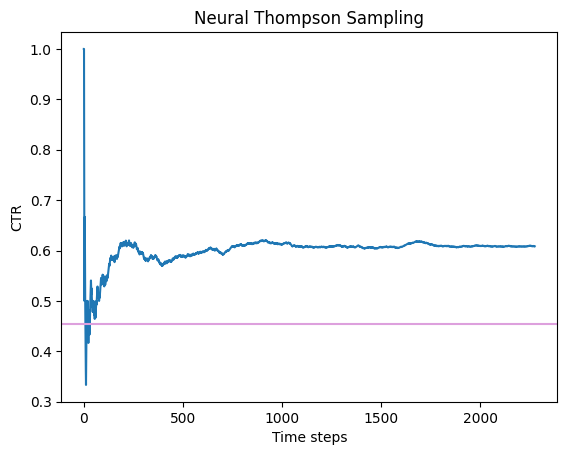

In [48]:
plt.plot(saved_neural_thompson_sampling_m20["ctr"])
plt.axhline(y = reward_mean, color = "plum")
plt.title("Neural Thompson Sampling")
plt.xlabel("Time steps")
plt.ylabel("CTR")